In [2]:
import time
import sys
#!{sys.executable} -m pip install [arg]


import torch
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree


import numpy as np
from itertools import permutations

# Example

In [3]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)

x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

In [4]:
data = Data(x=x, edge_index=edge_index)

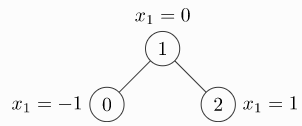

# Model

`propagate()` internally calls `message()`, `aggregate()` and `update()`

In [10]:
class Graph(MessagePassing):
    
    
    def __init__(self, N, w_init):
        """
        N      : number of agent nodes
        w_init : initial wealth of agents
        """
        # construct edges
        pairs = list(permutations(range(N), 2))    
        edge_index = torch.tensor(pairs, dtype=torch.long).t().contiguous()

        # initial wealth levels
        x = torch.tensor([[w_init]*N], dtype=torch.float).t()

        # construct Data object
        # weights all equal since wealth distribution is uniform initially
        self.data = Data(x=x, edge_index=edge_index, edge_weights=torch.ones(edge_index.shape))
        
        
    def forward(self):
        pass
    

    def message(self):
        pass

In [5]:
def connection_probability(D, alpha, b, num):
    return 1/(1+np.exp(alpha*(D-b))) > num

In [17]:
G = Graph(4, 0.1)
G.data.edge_index

tensor([[0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3],
        [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]])